In [10]:
import sys
sys.path.insert(0,"src/")

import benchscofi
import benchscofi.utils

from importlib import reload
from benchscofi.utils import prior_estimation

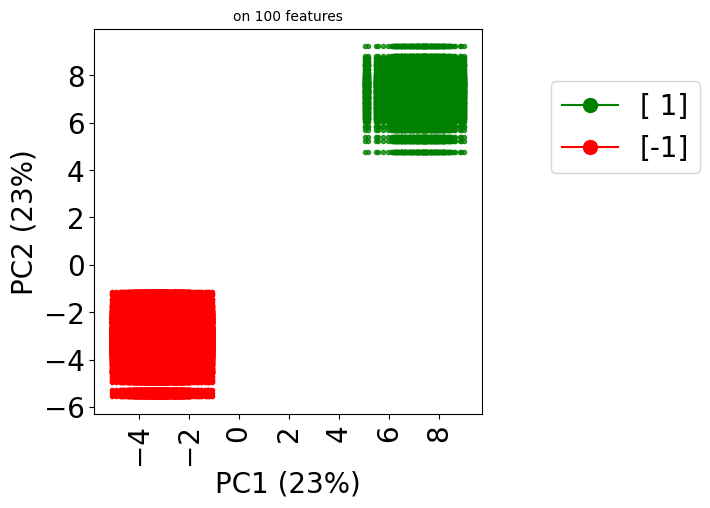

In [26]:
import stanscofi.datasets

rseed=12345

N=500
true_pi=0.3

npositive, nnegative, nfeatures, mean, std = int(true_pi*N), N-int(true_pi*N), 100, 1, 1
data_args = stanscofi.datasets.generate_dummy_dataset(npositive,nnegative,nfeatures,mean,std,random_state=rseed)
dataset = stanscofi.datasets.Dataset(**data_args)

dataset.visualize(withzeros=False)

2023-06-26 16:28:09.463279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [250000,100]
	 [[{{node Placeholder/_10}}]]
2023-06-26 16:28:09.463542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [250000,100]
	 [[{{node Placeholder/_11}}]]


<validation.compute_metrics> Computed on #users=500, 350 ignored (70 perc)


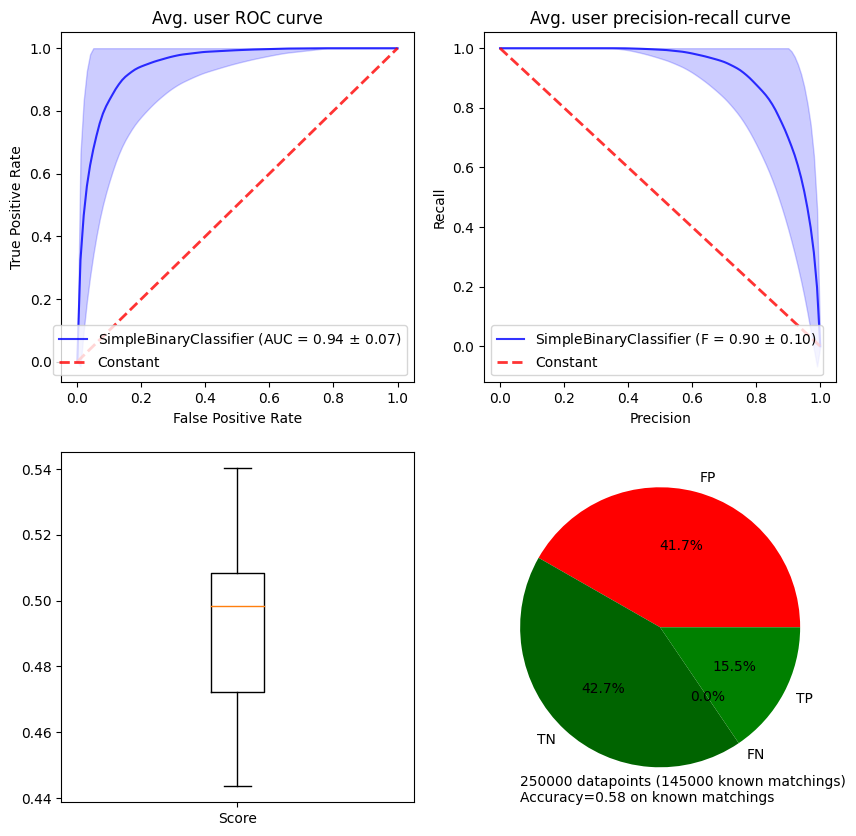

,Avg. across users,Std
AUC,0.944841,0.067987
F_1.0,0.899901,0.100117


In [41]:
import benchscofi.SimpleBinaryClassifier
from stanscofi.validation import compute_metrics, plot_metrics

## Model parameters
params = {"decision_threshold": 0.5, "preprocessing_str": "meanimputation_standardize", 
         "layers_dims": [16,32,64], "subset": None,
         "steps_per_epoch": 10, "epochs": 50, "random_state": 12324}

model = benchscofi.SimpleBinaryClassifier.SimpleBinaryClassifier(params)
model.fit(dataset)

## Predict the model on the testing dataset
scores = model.predict(dataset)
predictions = model.classify(scores)

## Validate the model on the testing dataset
metrics, plot_args = compute_metrics(scores, predictions, dataset, ignore_zeroes=False, verbose=True)
plot_metrics(**plot_args, figsize=(10,10), model_name=model.name)
metrics

In [61]:
from benchscofi.utils import prior_estimation
reload(prior_estimation)

<module 'benchscofi.utils.prior_estimation' from '/media/kali/1b80f30d-2803-4260-a792-9ae206084252/RECeSS/benchscofi/src/benchscofi/utils/prior_estimation.py'>

In [50]:
e1, e2, e3 = [prior_estimation.data_aided_estimation(model, dataset, estimator_type=i) for i in [1,2,3]]
e1, e2, e3

2023-06-26 16:31:15.811102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [250000,100]
	 [[{{node Placeholder/_11}}]]
2023-06-26 16:31:15.811376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [250000,100]
	 [[{{node Placeholder/_11}}]]
2023-06-26 16:31:20.779501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float a

(0.9997777777777778, 0.19085070460773584, 1.0)

In [53]:
pi_star = prior_estimation.roc_aided_estimation(model, dataset, ignore_zeroes=False, regression_type=[1,2][0])
pi_star

2023-06-26 16:32:35.673095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [250000,100]
	 [[{{node Placeholder/_11}}]]
2023-06-26 16:32:35.673345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [250000,100]
	 [[{{node Placeholder/_11}}]]
/media/kali/1b80f30d-2803-4260-a792-9ae206084252/RECeSS/benchscofi/src/benchscofi/utils/prior_estimation.py:52: RuntimeWarning: divide by zero encountered in log
  return -2*np.sum( np.multiply(mean_tprs, np.log(f(base_fprs))) + np.multiply(1-mean_tprs, np.log(1-f(base_fprs))) )
/media/kali/1b80f3

KeyError: 0

In [62]:
pi_hat = prior_estimation.divergence_aided_estimation(dataset, "meanimputation_standardize", lmb=1., sigma=1., 
                                                      divergence_type=["L1-distance","Pearson"][0])
pi_hat 

KeyboardInterrupt: 